In [1]:
import pandas as pd
import numpy as np

from datetime import datetime

from sklearn import decomposition
from sklearn.ensemble import *
from sklearn.feature_selection import *
from sklearn.model_selection import *
from sklearn.preprocessing import *

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

import csv
import time
import copy
import os
import tempfile

In [41]:
data = pd.read_csv('train_no_missing_merged.csv')
data.head()

,intersection_id,tollgate_id,avg_travel_time,w_month,w_week,w_day,w_dayofweek,w_hour,w_minute,pressure,...,ls_8_length,ls_8_ls_9_lane_diff,ls_8_out_top#,ls_9,ls_9_in_out_diff,ls_9_in_top#,ls_9_lanes,ls_9_length,ls_9_ls_10_lane_diff,ls_9_out_top#
0,A,2,58.05,7,29,19,1,0,20,0.248927,...,0.0,0,0,NaN,0,0,0,0.0,0,0
1,A,2,56.87,7,29,19,1,1,20,0.248927,...,0.0,0,0,NaN,0,0,0,0.0,0,0
2,A,2,77.74,7,29,19,1,1,40,0.248927,...,0.0,0,0,NaN,0,0,0,0.0,0,0
3,A,2,42.64,7,29,19,1,2,20,0.248927,...,0.0,0,0,NaN,0,0,0,0.0,0,0
4,A,2,40.17,7,29,19,1,2,40,0.248927,...,0.0,0,0,NaN,0,0,0,0.0,0,0


In [42]:
data_missing = pd.read_csv('train_missing_merged.csv')
data_missing.head()

,intersection_id,tollgate_id,avg_travel_time,w_month,w_week,w_day,w_dayofweek,w_hour,w_minute,pressure,...,ls_8_length,ls_8_ls_9_lane_diff,ls_8_out_top#,ls_9,ls_9_in_out_diff,ls_9_in_top#,ls_9_lanes,ls_9_length,ls_9_ls_10_lane_diff,ls_9_out_top#
0,A,2,85.405,7,29,19,1,0,0,0.248927,...,0.0,0,0,NaN,0,0,0,0.0,0,0
1,A,2,67.895,7,29,19,1,0,40,0.248927,...,0.0,0,0,NaN,0,0,0,0.0,0,0
2,A,2,67.895,7,29,19,1,1,0,0.248927,...,0.0,0,0,NaN,0,0,0,0.0,0,0
3,A,2,58.955,7,29,19,1,2,0,0.248927,...,0.0,0,0,NaN,0,0,0,0.0,0,0
4,A,2,39.800,7,29,19,1,3,0,0.231760,...,0.0,0,0,NaN,0,0,0,0.0,0,0


In [45]:
def cyclic_encoding(df):
    df_new = df.copy()
    cyclic_columns = ['w_month', 'w_week', 'w_day', 'w_dayofweek', 'w_hour', 'w_minute']
    for c in cyclic_columns:
        df_new[c+'_sin'] = np.sin(2 * np.pi * df_new[c]/23.0)
        df_new[c+'_cos'] = np.cos(2 * np.pi * df_new[c]/23.0)
        df_new.drop(c, axis=1, inplace=True)
    return df_new

def categorical_encoding(df):
    df_new = df.copy()
    categorical_columns = ['intersection_id', 'tollgate_id', 'ls_0', 'ls_1', 'ls_10', 'ls_11', 
                           'ls_2', 'ls_3', 'ls_4', 'ls_5', 'ls_6', 'ls_8', 'ls_7', 'ls_9']
    for c in categorical_columns:
        dummy = pd.get_dummies(df_new[c], dummy_na=False, prefix=c)
        df_new = pd.concat([df_new, dummy], axis=1)
        df_new.drop(c, axis=1, inplace=True)
    return df_new

In [46]:
data_n = cyclic_encoding(data)
data_n = categorical_encoding(data_n)
data_n = data_n.fillna(0)
data_n.head()

,avg_travel_time,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation,ls_0_in_out_diff,ls_0_in_top#,...,ls_5_117.0,ls_6_103.0,ls_6_118.0,ls_6_121.0,ls_8_101.0,ls_8_113.0,ls_7_106.0,ls_7_116.0,ls_7_122.0,ls_9_121.0
0,58.05,0.248927,0.25,0.608333,0.44,0.529644,0.767123,0.0,-1,0,...,1,0,0,0,0,0,0,0,0,0
1,56.87,0.248927,0.25,0.608333,0.44,0.529644,0.767123,0.0,-1,0,...,1,0,0,0,0,0,0,0,0,0
2,77.74,0.248927,0.25,0.608333,0.44,0.529644,0.767123,0.0,-1,0,...,1,0,0,0,0,0,0,0,0,0
3,42.64,0.248927,0.25,0.608333,0.44,0.529644,0.767123,0.0,-1,0,...,1,0,0,0,0,0,0,0,0,0
4,40.17,0.248927,0.25,0.608333,0.44,0.529644,0.767123,0.0,-1,0,...,1,0,0,0,0,0,0,0,0,0


In [48]:
data_missing_n = cyclic_encoding(data_missing)
data_missing_n = categorical_encoding(data_missing_n)
data_missing_n = data_missing_n.fillna(0)
data_missing_n.head()

,avg_travel_time,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation,ls_0_in_out_diff,ls_0_in_top#,...,ls_5_117.0,ls_6_103.0,ls_6_118.0,ls_6_121.0,ls_8_101.0,ls_8_113.0,ls_7_106.0,ls_7_116.0,ls_7_122.0,ls_9_121.0
0,85.405,0.248927,0.250000,0.608333,0.440000,0.529644,0.767123,0.0,-1,0,...,1,0,0,0,0,0,0,0,0,0
1,67.895,0.248927,0.250000,0.608333,0.440000,0.529644,0.767123,0.0,-1,0,...,1,0,0,0,0,0,0,0,0,0
2,67.895,0.248927,0.250000,0.608333,0.440000,0.529644,0.767123,0.0,-1,0,...,1,0,0,0,0,0,0,0,0,0
3,58.955,0.248927,0.250000,0.608333,0.440000,0.529644,0.767123,0.0,-1,0,...,1,0,0,0,0,0,0,0,0,0
4,39.800,0.231760,0.228814,0.588889,0.506667,0.695652,0.547945,0.0,-1,0,...,1,0,0,0,0,0,0,0,0,0


In [49]:
train_data, val_data = train_test_split(data_n, test_size=0.20, shuffle=False)

train_target = np.array(train_data.pop('avg_travel_time'))
val_target = np.array(val_data.pop('avg_travel_time'))

In [50]:
def mape(y_true, y_pred):
    return K.mean(K.abs((y_true - y_pred) / y_true), axis=-1)

def build_model(dim):
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_dim=dim,
                     kernel_regularizer=L1L2(l1=0.0,l2=0.001)),
        layers.Dense(64, activation='relu',
                     kernel_regularizer=L1L2(l1=0.0,l2=0.001)),
        layers.Dense(16, activation='relu',
                    kernel_regularizer=L1L2(l1=0.0,l2=0.001)),
        layers.Dense(8, activation='relu',
                    kernel_regularizer=L1L2(l1=0.0,l2=0.001)),
        layers.Dense(1,activation='linear')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

    model.compile(loss='mae',
                  optimizer=optimizer,
                  metrics=[mape])
    
    return model

class PrintProgress(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print('.', end='')
        if (epoch+1) % 10 == 0: 
            print(' ')
            logs_new = copy.deepcopy(logs)
            print(logs_new)


In [51]:
# early_stop = EarlyStopping(monitor='val_loss', patience=30, mode='min', verbose=1)            
            
EPOCHS = 50

model = build_model(train_data.shape[1])

history = model.fit(
    train_data, train_target,
    shuffle=False,
    epochs=EPOCHS, verbose=0, validation_data=(val_data, val_target), batch_size=100,
    callbacks=[PrintProgress()])

.......... 
{'loss': 25.89253130558857, 'mape': 0.24975602, 'val_loss': 53.593432625379734, 'val_mape': 0.25472227}
.......... 
{'loss': 25.71199698451737, 'mape': 0.2484444, 'val_loss': 52.30227474380284, 'val_mape': 0.2492648}
.......... 
{'loss': 25.67612526211133, 'mape': 0.24830192, 'val_loss': 51.531668771685744, 'val_mape': 0.24718177}
.......... 
{'loss': 25.539768310023458, 'mape': 0.24676853, 'val_loss': 51.956848659579855, 'val_mape': 0.24802345}
.......... 
{'loss': 25.46752509814781, 'mape': 0.24583453, 'val_loss': 51.496426749025574, 'val_mape': 0.24565405}


In [52]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')
    plt.legend()
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['mape'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mape'],
           label = 'Val Error')
    plt.legend()
    
    plt.show()

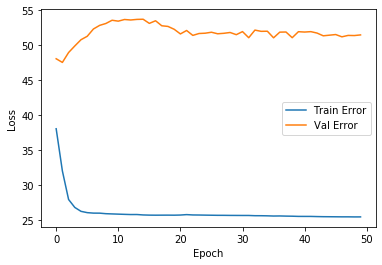

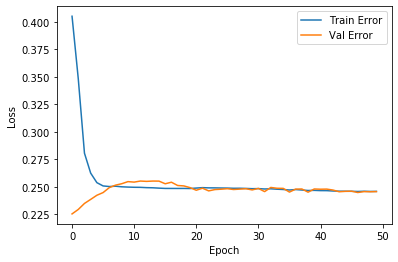

In [53]:
plot_history(history)

In [54]:
data_missing_n.pop('avg_travel_time')

0         85.405
1         67.895
2         67.895
3         58.955
4         39.800
5         75.810
6        193.365
7         40.340
8         40.340
9         72.595
10        67.845
11        52.845
12        98.855
13        98.855
14        98.855
15        98.855
16        98.855
17        98.855
18        98.855
19        98.855
20        98.855
21        98.855
22        98.855
23        98.855
24        98.855
25        98.855
26        98.855
27        98.855
28        98.855
29        98.855
          ...   
14132    201.410
14133    201.410
14134    201.410
14135    201.410
14136    201.410
14137    201.410
14138    201.410
14139    201.410
14140    201.410
14141    201.410
14142    201.410
14143    201.410
14144    201.410
14145    209.415
14146    209.415
14147    162.290
14148    146.135
14149    146.135
14150    146.135
14151    149.180
14152    170.115
14153    218.810
14154    218.810
14155    186.100
14156    324.255
14157    137.735
14158    155.525
14159    202.1

In [55]:
result = model.predict(np.array(data_missing_n))
result

array([[ 54.584538],
       [ 54.80834 ],
       [ 53.867996],
       ...,
       [119.65152 ],
       [117.79583 ],
       [116.10494 ]], dtype=float32)

In [56]:
data_missing['avg_travel_time'] = [r[0] for r in result]
data_missing.head()

,intersection_id,tollgate_id,avg_travel_time,w_month,w_week,w_day,w_dayofweek,w_hour,w_minute,pressure,...,ls_8_length,ls_8_ls_9_lane_diff,ls_8_out_top#,ls_9,ls_9_in_out_diff,ls_9_in_top#,ls_9_lanes,ls_9_length,ls_9_ls_10_lane_diff,ls_9_out_top#
0,A,2,54.584538,7,29,19,1,0,0,0.248927,...,0.0,0,0,NaN,0,0,0,0.0,0,0
1,A,2,54.808338,7,29,19,1,0,40,0.248927,...,0.0,0,0,NaN,0,0,0,0.0,0,0
2,A,2,53.867996,7,29,19,1,1,0,0.248927,...,0.0,0,0,NaN,0,0,0,0.0,0,0
3,A,2,53.637150,7,29,19,1,2,0,0.248927,...,0.0,0,0,NaN,0,0,0,0.0,0,0
4,A,2,53.603619,7,29,19,1,3,0,0.231760,...,0.0,0,0,NaN,0,0,0,0.0,0,0


In [57]:
data_missing.to_csv('train_all.csv', sep=',', encoding='utf-8', index=False)